# Model-free Pulse Gate Calibration using Reinforcement Learning

In this notebook, we adjust the definition of the gate to be a custom pulse sequence to be simulated by Qiskit-Dynamics package.

This notebook combines previously introduced modules of Qiskit and Tensorflow, combined to the usage of Qiskit-Dynamics to handle a pulse level simulation.

In [1]:
import numpy as np
import os
import sys

module_path = os.path.abspath(
    os.path.join(
        "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from qconfig import QiskitConfig
from helper_functions import (
    select_optimizer,
    generate_model,
    get_control_channel_map,
    get_solver_and_freq_from_backend,
)

# Qiskit imports for building RL environment (circuit level)
from qiskit import pulse, transpile, schedule
from qiskit.quantum_info import Operator
from qiskit.providers.options import Options
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta
from qiskit.providers import QubitProperties, Backend, BackendV1, BackendV2
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_dynamics.array import Array
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library.standard_gates import CXGate, XGate, SXGate, RZGate

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from typing import Optional, Union, List

# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend

Array.set_default_backend("jax")

# Defining QuantumEnvironment features

We provide below the details of our custom Quantum Processing Unit (QPU) we are controlling.

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```qubit_tgt_register```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neigbor coupling.
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- The dimension of the action vector: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible by using resources of another module of Qiskit called Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"pulse"```. Another notebook at the gate level is available in the repo.

In [63]:
def count_parameters(instructions: pulse.Schedule):
    cx_pulses = np.array(cx_instructions.instructions)[:, 1]
    counts = {"phases": 0, "pulse_params": 0, "total": 0}
    for instruction in cx_pulses:
        if isinstance(instruction, pulse.ShiftPhase):
            counts["phases"] += 1
            counts["total"] += 1
        else:
            counts["pulse_params"] += 4
            counts["total"] += 4
    return counts

In [4]:
def determine_cr_params(backend: Backend, qubit_tgt_register: list, basis_gate="cx"):
    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()
    cx_instructions = instruction_schedule_map.get(
        basis_gate, qubits=qubit_tgt_register
    )
    cx_pulses = np.array(cx_instructions.instructions)[:, 1]
    control_pulse = target_pulse = None
    for pulse in list(cx_pulses):
        name = str(pulse.name)
        if not name.find("CR90p_d") == -1:
            target_pulse = pulse.pulse
        if not name.find("CR90p_u") == -1:
            control_pulse = pulse.pulse

    params = {
        "amp": control_pulse.amp,
        "amp_t": target_pulse.amp,
        "angle": control_pulse.angle,
        "angle_t": target_pulse.angle,
        "duration": control_pulse.duration,
        "sigma": control_pulse.sigma,
        "width": control_pulse.width,
    }
    return params, cx_instructions, cx_pulses

In [67]:
def custom_cx_pulse_schedule(
    backend: Backend,
    physical_qubits: list,
    params: ParameterVector,
    default_params: dict,
    cx_instructions: pulse.Schedule,
):
    """
    Define parametrization of the pulse schedule characterizing the target gate
        :param backend: IBM Backend on which schedule shall be added
        :param qubit_tgt_register: Qubit register on which
        :param params: Parameters of the Schedule
        :param default_schedule:  baseline from which one can customize the pulse parameters

        :return: Parametrized Schedule
    """
    cx_pulses = np.array(cx_instructions.instructions)[:, 1]
    control_qubit, target_qubit = physical_qubits
    index = 0
    duration_variability = 0
    # Look here for the pulse features to specifically optimize upon, for the cx gate here,
    with pulse.build(
        backend=backend, name="param_schedule", default_alignment="left"
    ) as parametrized_schedule:
        for instruction in cx_pulses:
            if isinstance(instruction, pulse.ShiftPhase):
                pulse.shift_phase(
                    instruction.phase + params[index],
                    instruction.channel,
                    instruction.name,
                )
                index += 1
            elif instruction.pulse.pulse_type == "GaussianSquare":
                pulse_params = instruction.pulse.parameters
                for key in ("amp", "duration", "angle"):
                    param = (
                        params[index]
                        if key != "duration"
                        else pulse.builder.seconds_to_samples(
                            duration_variability * params[index]
                        )
                    )
                    pulse_params[key] += param
                    index += 1

        #             else:
        #                 pulse_params = instruction.pulse.parameters
        #                 pulse_params["amp"]+= params[index]
        #                 index += 1

        #                 pulse_params["angle"] += params[index]
        #                 index += 1

        #                 pulse_params["duration"] += pulse.builder.seconds_to_samples(duration_variability * params[index])
        #                 index += 1

        #                 pulse.shift_frequency(1e7*params[index], instruction.channel, name=instruction.name + "_shift_freq")
        #                 index += 1

        #                 if instruction.pulse.pulse_type == 'Drag':
        #                     pulse.play(pulse.Drag(**pulse_params), instruction.channel, instruction.name)
        #                 else: # GaussianSquare pulse
        #                     pulse.play(pulse.GaussianSquare(**pulse_params), instruction.channel, instruction.name)
        return parametrized_schedule

In [68]:
# Pulse gate ansatz


def apply_cx_parametrized_circuit(
    qc: QuantumCircuit,
    params: Optional[ParameterVector] = None,
    tgt_register: Optional[QuantumRegister] = None,
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :return:
    """
    # qc.num_qubits
    global n_actions, backend, physical_qubits, default_params, cx_instructions

    # x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit_tgt_register,)).instructions[0][1].pulse
    if params is None:
        params = ParameterVector("theta", n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]
    # original_calibration = backend.instruction_schedule_map.get(target["name"])

    parametrized_gate = Gate("custom_cx", 2, params=params.params)
    parametrized_schedule = custom_cx_pulse_schedule(
        backend=backend,
        physical_qubits=physical_qubits,
        params=params,
        default_params=default_params,
        cx_instructions=cx_instructions,
    )
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

In [69]:
physical_qubits = [24, 25]  # Choose which qubits of the QPU you want to address
sampling_Paulis = 200
N_shots = 10  # Number of shots for sampling the quantum computer for each action vector
n_actions = 31  # Choose how many control parameters in pulse/circuit parametrization
abstraction_level = (
    "pulse"  # Choose at which abstraction level the circuit ansatz is written
)
estimator_options = {"resilience_level": 0}

Choose below which IBM Backend to use. As we are dealing with pulse level implementation, we can either simulate a backend using QiskitDynamics, or use a real backend that supports OpenPulse features.

## 1. Setting up a Quantum Backend

### Real backend initialization

Uncomment the cell below to declare a Qiskit Runtime backend. You need an internet connection and an IBM Id account to access this.

In [90]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend, where Qiskit Runtime is enabled
"""
backend_name = "ibm_hanoi"

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q-nus/default/default"
)
runtime_backend = service.get_backend(backend_name)
runtime_backend

<IBMBackend('ibm_hanoi')>

In [89]:
runtime_backend.operation_names

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'delay']

In [91]:
runtime_backend.operation_names

['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay']

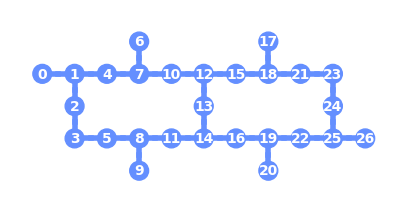

In [13]:
from qiskit.visualization import (
    plot_coupling_map,
    plot_circuit_layout,
    gate_map,
    plot_gate_map,
)
from qiskit.visualization.pulse_v2 import IQXDebugging

plot_gate_map(runtime_backend)

In [64]:
default_params, cx_instructions, cx_pulses = determine_cr_params(
    backend=runtime_backend, qubit_tgt_register=[24, 25]
)
cx_instructions.draw(style=IQXDebugging())
count_parameters(cx_instructions)

{'phases': 3, 'pulse_params': 28, 'total': 31}

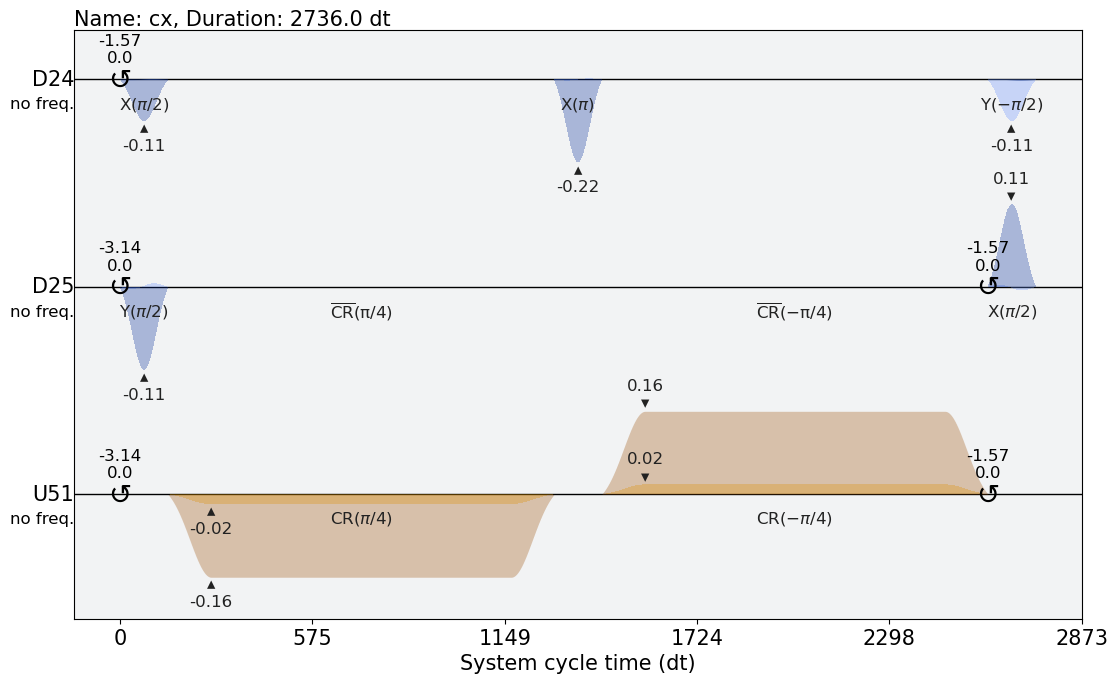

In [16]:
default_params, cx_instructions, cx_pulses = determine_cr_params(
    backend=runtime_backend, qubit_tgt_register=[25, 24]
)
cx_instructions.draw(IQXDebugging())

In [33]:
default_params

{'amp': 0.25477304879762536,
 'amp_t': 0.054244646360068816,
 'angle': 1.7763326364430851,
 'angle_t': -0.006994641142898962,
 'duration': 768,
 'sigma': 64,
 'width': 512}

In [18]:
cx_instructions

Schedule((0, ShiftPhase(-1.5707963267948966, DriveChannel(24))), (0, ShiftPhase(-3.141592653589793, DriveChannel(25))), (0, ShiftPhase(-3.141592653589793, ControlChannel(47))), (0, ShiftPhase(-1.5707963267948966, ControlChannel(49))), (0, ShiftPhase(-3.141592653589793, ControlChannel(51))), (0, ShiftPhase(-1.5707963267948966, ControlChannel(53))), (0, ShiftPhase(-3.141592653589793, ControlChannel(55))), (0, Play(Drag(duration=144, sigma=36, beta=-0.9379774831037209, amp=0.11140880134125607, angle=0.014092661857556463, name='X90p_d24'), DriveChannel(24), name='X90p_d24')), (0, Play(Drag(duration=144, sigma=36, beta=-2.18882000203277, amp=0.11196802036955632, angle=1.584469805652993, name='Y90p_d25'), DriveChannel(25), name='Y90p_d25')), (144, Play(GaussianSquare(duration=1152, sigma=64, width=896, amp=0.0, angle=0.0, name='CR90p_d25_u51'), DriveChannel(25), name='CR90p_d25_u51')), (144, Play(GaussianSquare(duration=1152, sigma=64, width=896, amp=0.16325025321597642, angle=1.451999456694

In [17]:
cx_pulses

array([ShiftPhase(-1.5707963267948966, DriveChannel(24)),
       ShiftPhase(-3.141592653589793, DriveChannel(25)),
       ShiftPhase(-3.141592653589793, ControlChannel(47)),
       ShiftPhase(-1.5707963267948966, ControlChannel(49)),
       ShiftPhase(-3.141592653589793, ControlChannel(51)),
       ShiftPhase(-1.5707963267948966, ControlChannel(53)),
       ShiftPhase(-3.141592653589793, ControlChannel(55)),
       Play(Drag(duration=144, sigma=36, beta=-0.9379774831037209, amp=0.11140880134125607, angle=0.014092661857556463, name='X90p_d24'), DriveChannel(24), name='X90p_d24'),
       Play(Drag(duration=144, sigma=36, beta=-2.18882000203277, amp=0.11196802036955632, angle=1.584469805652993, name='Y90p_d25'), DriveChannel(25), name='Y90p_d25'),
       Play(GaussianSquare(duration=1152, sigma=64, width=896, amp=0.0, angle=0.0, name='CR90p_d25_u51'), DriveChannel(25), name='CR90p_d25_u51'),
       Play(GaussianSquare(duration=1152, sigma=64, width=896, amp=0.16325025321597642, angle=1.45

In [45]:
cx_pulses[8].pulse.parameters

{'duration': 144,
 'sigma': 36,
 'beta': -2.18882000203277,
 'amp': 0.11196802036955632,
 'angle': 1.584469805652993}

In [42]:
cx_pulses[8].pulse.pulse_type

'Drag'

In [46]:
cx_pulses[9].pulse.parameters

{'duration': 1152, 'sigma': 64, 'width': 896, 'amp': 0.0, 'angle': 0.0}

In [56]:
cx_pulses[9].channel

DriveChannel(25)

In [24]:
my_phase = type(cx_pulses[0])(1.68, pulse.DriveChannel(24))

In [30]:
fake_backend = FakeHanoi()
cal = fake_backend.defaults().instruction_schedule_map.get("cx", (0, 1))
cal

Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(0))), (0, ShiftPhase(1.5707963267948966, ControlChannel(1))), (0, Play(Drag(duration=96, sigma=24, beta=-0.4950839561397558, amp=0.31697339848243977, angle=-1.5707963267948968, name='Ym_d0'), DriveChannel(0), name='Ym_d0')), (0, Play(Drag(duration=96, sigma=24, beta=0.9542241249038057, amp=0.1564730063304799, angle=-0.014423655916044217, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), (96, Play(GaussianSquare(duration=592, sigma=64, width=336, amp=0.05037140567822301, angle=-0.04438428670430894, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')), (96, Play(GaussianSquare(duration=592, sigma=64, width=336, amp=0.7383581080824689, angle=-2.5559240673393377, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')), (688, Play(Drag(duration=96, sigma=24, beta=-0.4950839561397558, amp=0.31697339848243977, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), (784, Play(GaussianSquare(duration=592, sigma=64, width=336, a

In [106]:
cx_pulses[7].channel.index

24

In [110]:
from qiskit.quantum_info.random import random_clifford
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag

qc = random_clifford(num_qubits=3, seed=42).to_circuit()
print(qc.draw())
dag = circuit_to_dag(qc)
for layer in dag.layers():
    for op in layer["graph"].op_nodes():
        print(op.qargs)
        print(op.op)

     ┌───┐┌───┐                     ┌───┐ ┌───┐          ┌─────┐┌───┐
q_0: ┤ Y ├┤ H ├─────────────────■───┤ H ├─┤ S ├───────■──┤ Sdg ├┤ H ├
     ├───┤├───┤┌───┐┌───┐       │   ├───┤ ├───┤     ┌─┴─┐└─────┘└───┘
q_1: ┤ X ├┤ S ├┤ H ├┤ S ├──■────┼───┤ H ├─┤ S ├──■──┤ X ├────────────
     ├───┤├───┤├───┤└───┘┌─┴─┐┌─┴─┐┌┴───┴┐├───┤┌─┴─┐└───┘            
q_2: ┤ Y ├┤ H ├┤ S ├─────┤ X ├┤ X ├┤ Sdg ├┤ H ├┤ X ├─────────────────
     └───┘└───┘└───┘     └───┘└───┘└─────┘└───┘└───┘                 
(Qubit(QuantumRegister(3, 'q'), 0),)
Instruction(name='y', num_qubits=1, num_clbits=0, params=[])
(Qubit(QuantumRegister(3, 'q'), 1),)
Instruction(name='x', num_qubits=1, num_clbits=0, params=[])
(Qubit(QuantumRegister(3, 'q'), 2),)
Instruction(name='y', num_qubits=1, num_clbits=0, params=[])
(Qubit(QuantumRegister(3, 'q'), 0),)
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
(Qubit(QuantumRegister(3, 'q'), 1),)
Instruction(name='s', num_qubits=1, num_clbits=0, params=[])
(Qubit(QuantumRegist

In [73]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend, where Qiskit Runtime is enabled
"""
backend_name = "ibm_nazca"

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q-nus/default/default"
)
runtime_backend = service.get_backend(backend_name)
runtime_backend

<IBMBackend('ibm_nazca')>

In [78]:
default_params, cx_instructions, cx_pulses = determine_cr_params(
    backend=runtime_backend, qubit_tgt_register=[25, 24], basis_gate="ecr"
)

In [70]:
backend = runtime_backend
qc = QuantumCircuit(2)
apply_cx_parametrized_circuit(qc)

In [72]:
qc.calibrations

{'custom_cx': {((Qubit(QuantumRegister(2, 'q'), 0),
    Qubit(QuantumRegister(2, 'q'), 1)),
   (ParameterVectorElement(theta[0]),
    ParameterVectorElement(theta[1]),
    ParameterVectorElement(theta[2]),
    ParameterVectorElement(theta[3]),
    ParameterVectorElement(theta[4]),
    ParameterVectorElement(theta[5]),
    ParameterVectorElement(theta[6]),
    ParameterVectorElement(theta[7]),
    ParameterVectorElement(theta[8]),
    ParameterVectorElement(theta[9]),
    ParameterVectorElement(theta[10]),
    ParameterVectorElement(theta[11]),
    ParameterVectorElement(theta[12]),
    ParameterVectorElement(theta[13]),
    ParameterVectorElement(theta[14]),
    ParameterVectorElement(theta[15]),
    ParameterVectorElement(theta[16]),
    ParameterVectorElement(theta[17]),
    ParameterVectorElement(theta[18]),
    ParameterVectorElement(theta[19]),
    ParameterVectorElement(theta[20]),
    ParameterVectorElement(theta[21]),
    ParameterVectorElement(theta[22]),
    ParameterVectorEl

In [79]:
def count_gates(qc):
    gate_count = {qubit: 0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit] += 1
    return gate_count


def remove_unused_wires(qc):
    gate_count = count_gates(qc)
    for qubit, count in gate_count.items():
        if count == 0:
            qc.qubits.remove(qubit)
    return qc

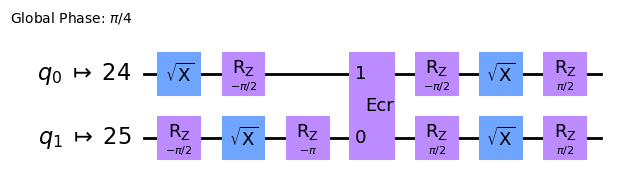

In [81]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
remove_unused_wires(transpile(qc, runtime_backend, initial_layout=[24, 25])).draw("mpl")

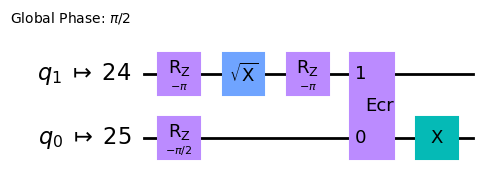

In [82]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
remove_unused_wires(transpile(qc, runtime_backend, initial_layout=[25, 24])).draw("mpl")

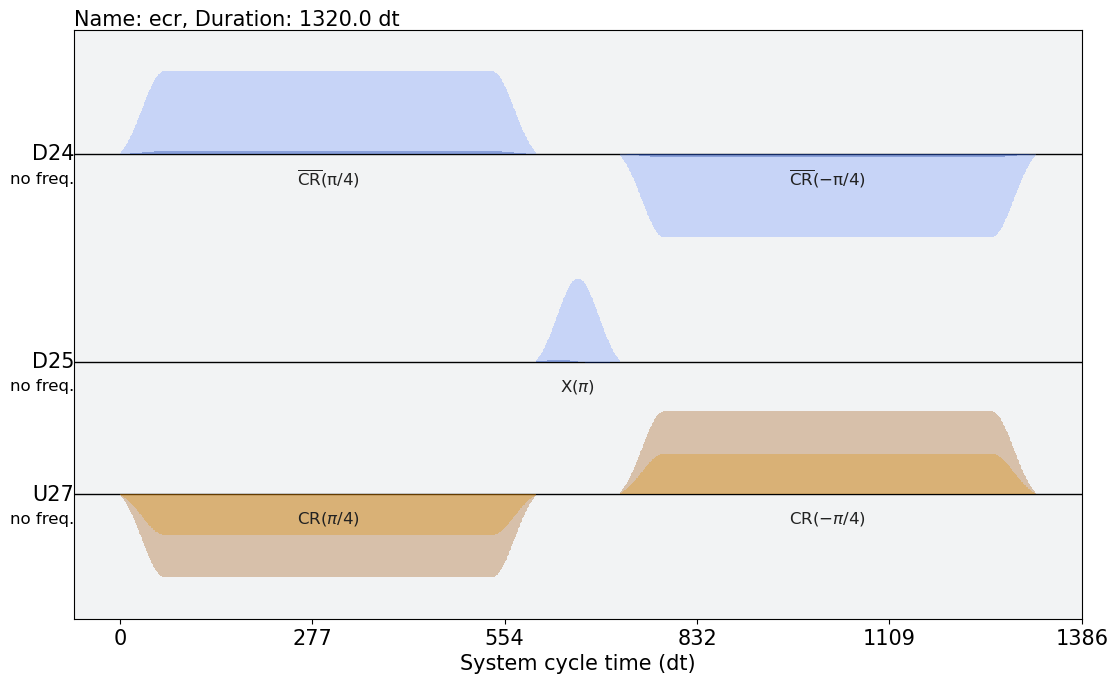

In [94]:
default_params, instructions, ecr_pulses = determine_cr_params(
    backend=runtime_backend, qubit_tgt_register=[25, 24], basis_gate="ecr"
)
instructions.draw()

In [84]:
runtime_simulator = service.get_backend("ibmq_qasm_simulator")

In [86]:
from qiskit.transpiler import InstructionDurations

runtime_simulator.instruction_durations.update(
    InstructionDurations.from_backend(FakeHanoi())
)

In [88]:
print(runtime_simulator.instruction_durations)

id(0,): 2.1333333333333332e-08 s
id(1,): 2.1333333333333332e-08 s
id(2,): 2.1333333333333332e-08 s
id(3,): 2.1333333333333332e-08 s
id(4,): 2.1333333333333332e-08 s
id(5,): 2.1333333333333332e-08 s
id(6,): 2.1333333333333332e-08 s
id(7,): 2.1333333333333332e-08 s
id(8,): 2.1333333333333332e-08 s
id(9,): 2.1333333333333332e-08 s
id(10,): 2.1333333333333332e-08 s
id(11,): 2.1333333333333332e-08 s
id(12,): 2.1333333333333332e-08 s
id(13,): 2.1333333333333332e-08 s
id(14,): 2.1333333333333332e-08 s
id(15,): 2.1333333333333332e-08 s
id(16,): 2.1333333333333332e-08 s
id(17,): 2.1333333333333332e-08 s
id(18,): 2.1333333333333332e-08 s
id(19,): 2.1333333333333332e-08 s
id(20,): 2.1333333333333332e-08 s
id(21,): 2.1333333333333332e-08 s
id(22,): 2.1333333333333332e-08 s
id(23,): 2.1333333333333332e-08 s
id(24,): 2.1333333333333332e-08 s
id(25,): 2.1333333333333332e-08 s
id(26,): 2.1333333333333332e-08 s
rz(0,): 0.0 s
rz(1,): 0.0 s
rz(2,): 0.0 s
rz(3,): 0.0 s
rz(4,): 0.0 s
rz(5,): 0.0 s
rz(6,): 

### Simulation backend initialization
If you want to run the algorithm over a simulation, you can rely on Qiskit Dynamics for pulse level simulation of quantum circuits. Below we set the ground for declaring a ```DynamicsBackend```.

This can be done in two ways: 

1. Declare a ```DynamicsBackend``` from a ```FakeBackend``` or ```IBMBackend``` instance and use the ```from_backend()``` method to retrieve the Hamiltonian description of such backend.
2. Alternatively, you can define your own custom Hamiltonian/Linblad that should be used to simulate the multiqubit system of interest, and feed it to a ```Solver``` instance which can be used to declare the ```DynamicsBackend```.
For more information you can check Qiskit Dynamics documentation (https://qiskit.org/documentation/dynamics/apidocs/backend.html)


#### 1. Using ```FakeBackend``` as starting point

In [6]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2

fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
control_channel_map = get_control_channel_map(fake_backend, qubit_tgt_register)
dt = fake_backend_v2.target.dt

In [7]:
dynamics_options = {
    "seed_simulator": None,  # "configuration": fake_backend.configuration(),
    "control_channel_map": control_channel_map,
    # Control channels to play CR tones, should match connectivity of device
    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt},
}
dynamics_backend = DynamicsBackend.from_backend(
    fake_backend, subsystem_list=qubit_tgt_register, **dynamics_options
)

target = dynamics_backend.target
target.qubit_properties = fake_backend_v2.qubit_properties(qubit_tgt_register)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=qubit_tgt_register,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None,
)
calibration_files = None

#### 2. Using a custom Hamiltonian model

In [8]:
r = 0.1e9

# Frequency of the qubit transition in GHz.
w = 5e9
# Sample rate of the backend in ns.
dt = 2.2222222e-10

drift = 2 * np.pi * w * Operator(Z) / 2
operators = [2 * np.pi * r * Operator(X) / 2]

hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5e9,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": w},
    dt=dt,
)

custom_backend = DynamicsBackend(hamiltonian_solver, **dynamics_options)

### Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [9]:
# Choose backend among the set defined above: {runtime_backend, dynamics_backend, custom_backend}
backend = dynamics_backend

In [10]:
# Wrap all info in one QiskitConfig
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    channel_freq=channel_freq,
    solver=solver,
    calibration_files=calibration_files,
)

## 2. Define quantum target: State preparation or Gate calibration

The target of our optimal control task can be of two different types:
1.  An arbitrary quantum state to prepare with high accuracy
2. A Quantum Gate to be calibrated in a noise-robust manner

Both targets are dictionaries that are identified with a key stating their ```target_type```, which can be either ```"state"``` or ```"gate"```.

For a gate target $G$, one can add the target quantum gate with a ```"gate"``` argument specifying a specific instance of a Qiskit ```Gate``` object. Here, we settle for calibrating a ```XGate()```.
Moreover, a gate calibration requires a set of input states $\{|s_i\rangle \}$ to be provided, such that the agent can try to set the actions such that the fidelity between the anticipated ideal target state (calculated as  $G|s_i\rangle$) and the output state are simultaneously maximized. To ensure a correlation between the average reward computed from the measurement outcomes and the average gate fidelity, the provided set of input states must be tomographically complete. Note that providing the set of ```input_states```as depicted below is optional and should be done only if you have a specific set to implement, by default it is internally set to the Pauli basis preparation stage.

For a state target, one can provide, similarly to an input state, an ideal circuit to prepare it (```"circuit": QuantumCircuit```, or a density matrix (key ```"dm": DensityMatrix```). Below, we settle for giving a ```QuantumCircuit```for each input state, from the elementary operations present in ```qiskit.opflow```(which will be deprecated soon, and should therefore be replaced in the future by the ```QuantumCircuit```itself.

Another important key that should figure in the dictionary is the ```"register"``` indicating the qubits indices that should be addressed by this target, i.e. upon which qubits should the target be engineered. The register can be a list of indices for qubits to be addressed in the circuit, or a ```QuantumRegister```object. If register is not provided, then by default the target register will be the list of all qubits defined up to ```Gate().num_qubits```.

In [11]:
# Example of target gate
X_tgt = {
    "target_type": "gate",
    "gate": XGate("X"),
    "register": qubit_tgt_register,
    "input_states": [
        {"name": "|0>", "circuit": I.to_circuit()},
        {"name": "|1>", "circuit": X.to_circuit()},
        {"name": "|+>", "circuit": H.to_circuit()},
        {"name": "|->", "circuit": (H @ X).to_circuit()},
    ],
}

# Example of target state

excited_tgt = {
    "target_type": "state",
    "gate": XGate("X"),  # "gate" key not expected for state target, here we
    # just use it for retrieving a pulse baseline in method custom_pulse_schedule
    "circuit": X.to_circuit(),
    "register": qubit_tgt_register,
}

In [12]:
# Choose which target to use
target = X_tgt

## 3. Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.

If selected backend is a ```DynamicsBackend```, this declaration launches a series of single qubit gate calibrations (to calibrate X and SX gate). The reason for this is that the Estimator primitive, which enables the easy calculation of Pauli expectation values, needs to append gates for doing Pauli basis rotations (SX and Rz gate).

In [13]:
%%time
q_env = QuantumEnvironment(
    target=target,
    abstraction_level=abstraction_level,
    Qiskit_config=Qiskit_setup,
    sampling_Pauli_space=sampling_Paulis,
    n_shots=N_shots,
    c_factor=0.5,
)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'t', 'sx', 'rz', 'x', 'id', 's', 'measure', 'tdg', 'h', 'reset', 'z', 'sdg'}
Multi qubit instructions:
)>
CPU times: user 16.6 s, sys: 277 ms, total: 16.9 s
Wall time: 18.8 s


In [14]:
print(backend.target.instruction_schedule_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'t', 'sx', 'rz', 'x', 'id', 's', 'measure', 'tdg', 'h', 'reset', 'z', 'sdg'}
Multi qubit instructions:
)>


# Defining the RL agent: PPO

In [15]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
%time
n_epochs = 200  # Number of epochs
batchsize = 50  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"  # Optimizer choice
eta = 0.001  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.1  # Parameter for clipping value (PPO)
grad_clip = 0.01
critic_loss_coeff = 0.5
optimizer = select_optimizer(
    lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2
)
sigma_eps = 1e-3  # for numerical stability

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs


In [16]:
"""
-----------------------------------------------------------------------------------------------------
Policy parameters
-----------------------------------------------------------------------------------------------------
"""
N_in = (
    n_qubits + 1
)  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [82, 82]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros(
    (1, N_in)
)  # Here no feedback involved, so measurement sequence is always the same

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 82)           246         input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 82)           6806        hidden_0[0][0]                   
__________________________________________________________________________________________________
mean_vec (Dense)                (None, 1)            83          hidden_1[0][0]                   
______________________________________________________________________________________________

In [17]:
# Plotting tools
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 5
%matplotlib inline
do_benchmark = False

## Run algorithm

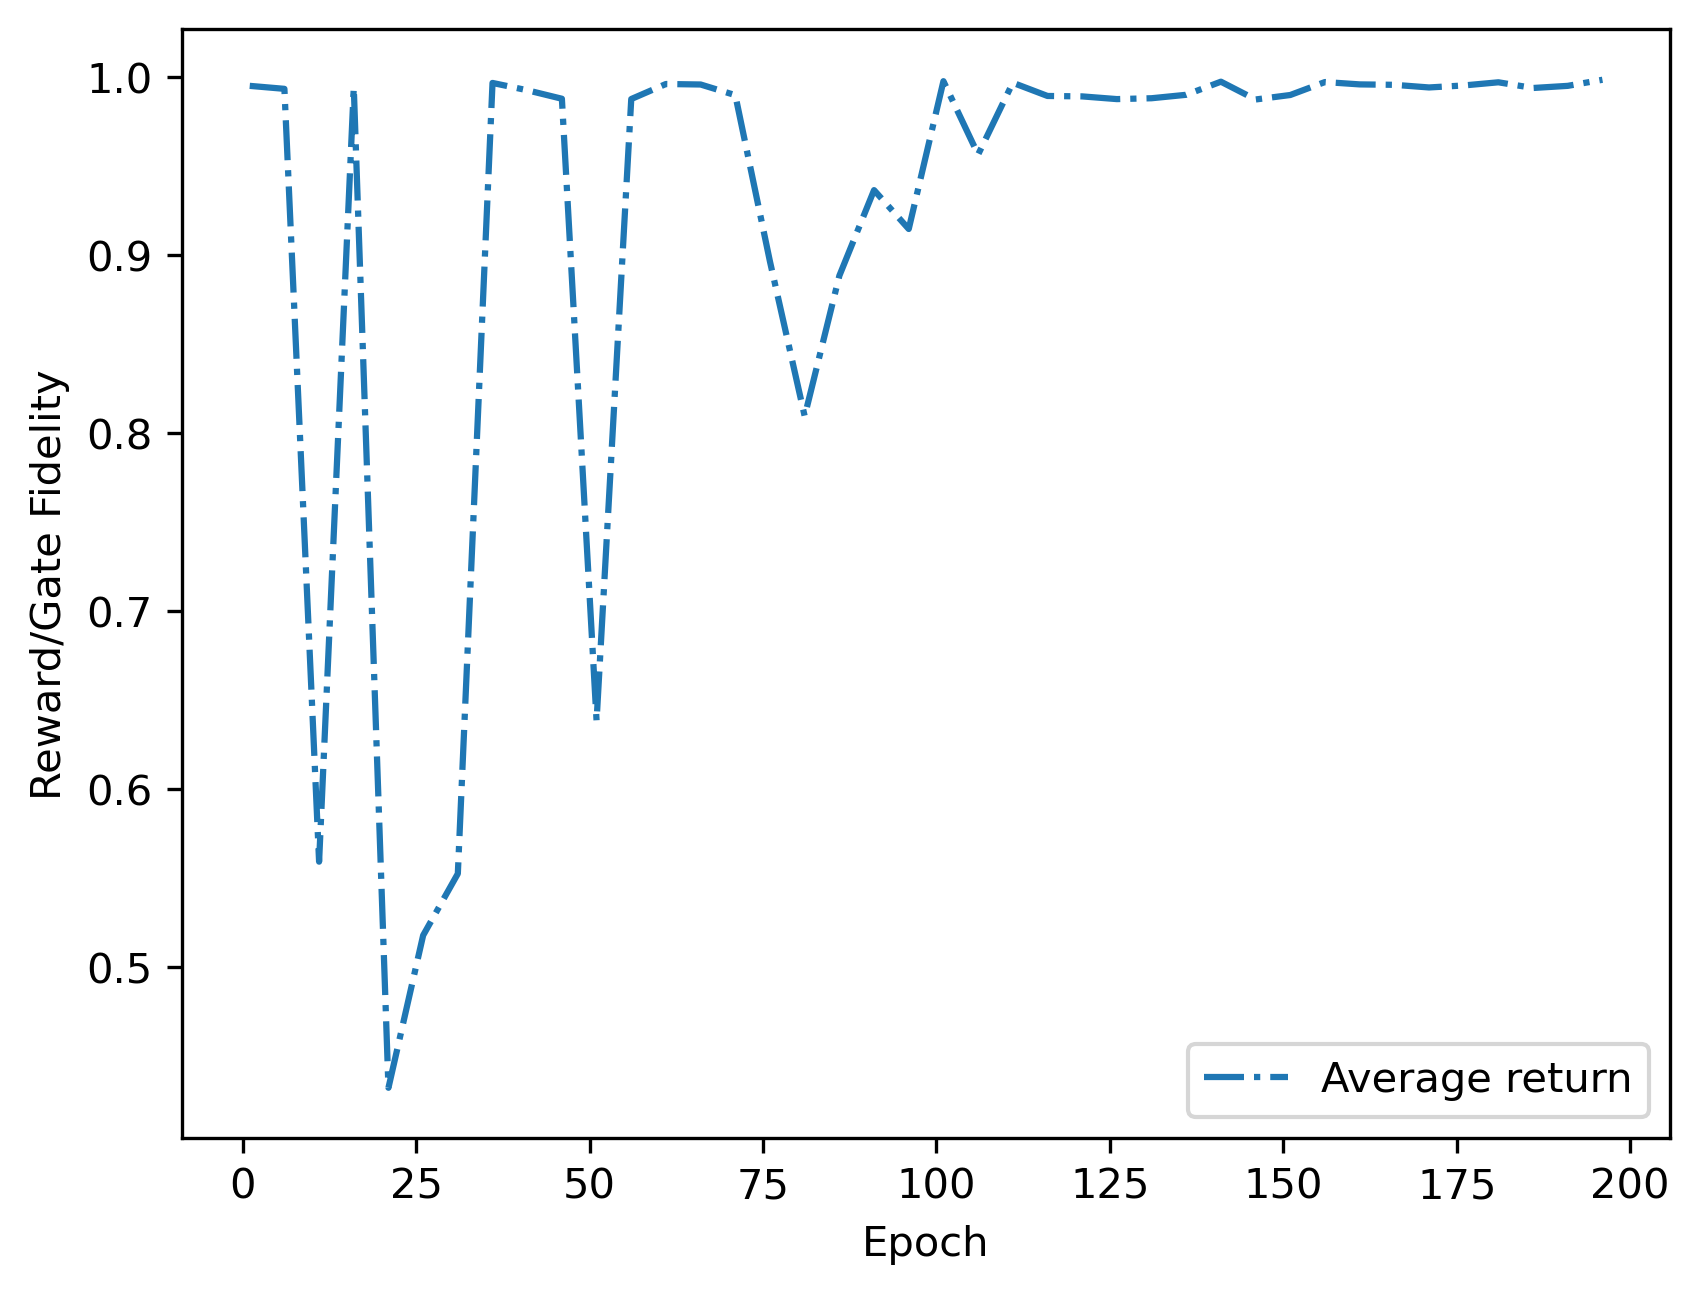

 98%|██████████████████████████████████████▏| 196/200 [1:04:33<02:27, 36.86s/it]

Maximum return reached so far: 0.9987800000000001 at Epoch 187

 Epoch 196


 98%|██████████████████████████████████████▍| 197/200 [1:05:09<01:50, 36.81s/it]

Policy params [0.17159674] +- [0.00427626]
Average reward 0.99858
Action batch [[0.17948785]
 [0.16790412]
 [0.16788986]
 [0.17763197]
 [0.17404222]
 [0.17251681]
 [0.1712884 ]
 [0.17394479]
 [0.16023964]
 [0.17159653]
 [0.16979669]
 [0.17518876]
 [0.17405951]
 [0.1690415 ]
 [0.17121403]
 [0.17087553]
 [0.17238268]
 [0.18172246]
 [0.17376481]
 [0.17545415]
 [0.1685736 ]
 [0.17359714]
 [0.1777393 ]
 [0.17119238]
 [0.1746184 ]
 [0.17239046]
 [0.16832307]
 [0.17416076]
 [0.17162745]
 [0.1684527 ]
 [0.17226087]
 [0.1728625 ]
 [0.17361073]
 [0.17622475]
 [0.16774745]
 [0.1700138 ]
 [0.17512377]
 [0.17304526]
 [0.17677191]
 [0.1715837 ]
 [0.17201674]
 [0.16435182]
 [0.17498182]
 [0.17489259]
 [0.17102015]
 [0.17304295]
 [0.1651965 ]
 [0.17554738]
 [0.16392134]
 [0.1724045 ]]

 Epoch 197


 99%|██████████████████████████████████████▌| 198/200 [1:05:47<01:13, 37.00s/it]

Policy params [0.17613845] +- [0.00420687]
Average reward 0.9886800000000001
Action batch [[0.18104509]
 [0.17797206]
 [0.17205776]
 [0.17455314]
 [0.18190223]
 [0.18691947]
 [0.18091276]
 [0.1828315 ]
 [0.17488661]
 [0.17342535]
 [0.17606884]
 [0.18141358]
 [0.17234068]
 [0.17639253]
 [0.17935862]
 [0.17361014]
 [0.18249053]
 [0.17595379]
 [0.17178692]
 [0.17500733]
 [0.18113725]
 [0.17599745]
 [0.1792314 ]
 [0.18055555]
 [0.17147152]
 [0.17689882]
 [0.17670472]
 [0.18014735]
 [0.17069809]
 [0.18000954]
 [0.17259587]
 [0.17554145]
 [0.17546989]
 [0.1727978 ]
 [0.17713886]
 [0.1743365 ]
 [0.1761695 ]
 [0.17349942]
 [0.17622569]
 [0.17965393]
 [0.172037  ]
 [0.17206436]
 [0.17239368]
 [0.1736257 ]
 [0.17466581]
 [0.17775539]
 [0.17990524]
 [0.17799836]
 [0.18007186]
 [0.17341426]]

 Epoch 198


100%|██████████████████████████████████████▊| 199/200 [1:06:25<00:37, 37.47s/it]

Policy params [0.17159714] +- [0.00414315]
Average reward 0.9893399999999999
Action batch [[0.17706127]
 [0.17160727]
 [0.16785821]
 [0.17041725]
 [0.16448055]
 [0.16470352]
 [0.17197019]
 [0.16658998]
 [0.17184721]
 [0.1702597 ]
 [0.1765752 ]
 [0.17314398]
 [0.16584226]
 [0.17329891]
 [0.17015688]
 [0.1760302 ]
 [0.17526177]
 [0.17078951]
 [0.16782942]
 [0.17231362]
 [0.17633791]
 [0.16956222]
 [0.16433565]
 [0.17199862]
 [0.1727083 ]
 [0.17486767]
 [0.17358619]
 [0.1708113 ]
 [0.1736928 ]
 [0.17309353]
 [0.16990982]
 [0.17594635]
 [0.16755873]
 [0.17865762]
 [0.17571661]
 [0.17429653]
 [0.17102373]
 [0.17405643]
 [0.17326035]
 [0.17114456]
 [0.16596648]
 [0.17701928]
 [0.17549244]
 [0.17219266]
 [0.17914684]
 [0.17394939]
 [0.17788132]
 [0.17001073]
 [0.17534594]
 [0.16423321]]

 Epoch 199


100%|███████████████████████████████████████| 200/200 [1:07:03<00:00, 20.12s/it]

Policy params [0.17613839] +- [0.0040703]
Average reward 0.99802
Action batch [[0.17255156]
 [0.17298426]
 [0.17914043]
 [0.17605087]
 [0.17249441]
 [0.1707099 ]
 [0.17434293]
 [0.17999408]
 [0.18174365]
 [0.16849938]
 [0.17327604]
 [0.17697324]
 [0.16912559]
 [0.17726998]
 [0.17236024]
 [0.18506835]
 [0.17757437]
 [0.17503764]
 [0.18024105]
 [0.17543401]
 [0.18158177]
 [0.17393331]
 [0.18075384]
 [0.17615382]
 [0.17701754]
 [0.1829548 ]
 [0.1797839 ]
 [0.18051787]
 [0.17766784]
 [0.18258166]
 [0.17334874]
 [0.17144856]
 [0.178812  ]
 [0.17488629]
 [0.175314  ]
 [0.1811381 ]
 [0.17641534]
 [0.17806076]
 [0.17783132]
 [0.16849314]
 [0.17785998]
 [0.17660443]
 [0.16980731]
 [0.17469487]
 [0.17695259]
 [0.1747131 ]
 [0.16405119]
 [0.16930847]
 [0.17554012]
 [0.17151396]]
CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 9.3 µs


In [18]:
"""
-----------------------------------------------------------------------------------------------------
Training loop
-----------------------------------------------------------------------------------------------------
"""

q_env.clear_history()
mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)


for i in tqdm(range(n_epochs)):
    Old_distrib = MultivariateNormalDiag(
        loc=mu_old, scale_diag=sigma_old, validate_args=True, allow_nan_stats=False
    )
    print("\n Epoch", i)

    with tf.GradientTape(persistent=True) as tape:
        mu, sigma, b = network(init_msmt, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(
            loc=mu, scale_diag=sigma, validate_args=True, allow_nan_stats=False
        )

        action_vector = tf.stop_gradient(
            tf.clip_by_value(Policy_distrib.sample(batchsize), -0.5, 0.5)
        )
        # Adjust the action vector according to params physical significance
        reward = q_env.perform_action(action_vector, do_benchmark)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (
                tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-6
            )
            actor_loss = -tf.reduce_mean(
                tf.minimum(
                    advantage * ratio,
                    advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon),
                )
            )
        else:  # REINFORCE algorithm
            actor_loss = -tf.reduce_mean(
                advantage * Policy_distrib.log_prob(action_vector)
            )

        critic_loss = tf.reduce_mean(advantage**2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)
    print("Policy params", np.array(mu), "+-", np.array(sigma))
    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)

    avg_return[i] = np.mean(q_env.reward_history, axis=1)[i]
    print("Average reward", avg_return[i])
    if do_benchmark:
        if target["target_type"] == "gate":
            fidelities[i] = q_env.avg_fidelity_history[i]
            print("Average Gate fidelity", fidelities[i])
        else:
            fidelities[i] = q_env.state_fidelity_history[i]
            print("State fidelity", fidelities[i])
    print("Action batch", q_env.action_history[i])
    if i % visualization_steps == 0:
        clear_output(wait=True)  # for animation
        fig, ax = plt.subplots()
        ax.plot(
            np.arange(1, n_epochs, visualization_steps),
            avg_return[0:-1:visualization_steps],
            "-.",
            label="Average return",
        )
        if do_benchmark:
            ax.plot(
                np.arange(1, n_epochs, visualization_steps),
                fidelities[0:-1:visualization_steps],
                label="Average Gate Fidelity",
            )
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Reward/Gate Fidelity")
        ax.legend()
        plt.show()
        if do_benchmark:
            print(
                "Maximum fidelity reached so far:",
                np.max(fidelities),
                "at Epoch",
                np.argmax(fidelities),
            )
        print(
            "Maximum return reached so far:",
            np.max(avg_return),
            "at Epoch",
            np.argmax(avg_return),
        )
        # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
if isinstance(q_env.estimator, Estimator):
    q_env.estimator.session.close()
%time